## Problem
Build a Deep Learning classification model that takes the hierarchy into consideration.
Take any 4 categories from the dataset (100 images each) such that there is a hierarchical relationship between them for eg:

Animals
- Dog
- Cat

~~Flowers~~ Fruits
- ~~Rose~~ Grapes
- ~~Sunflower~~ Pear

Build a Classification model for the above 4 categories, such that the penalty of inter-category prediction is higher.

## Import stuff

In [91]:
import os
import numpy as np
import sys
from PIL import Image
import PIL.ImageOps

from tqdm import tqdm_notebook
from matplotlib import pyplot as plt
import matplotlib.cm as cm
import random

import keras
from keras import layers as L
from keras import optimizers as opt
from keras.preprocessing.image import ImageDataGenerator

## Extract and save the image files (28x28) from .npy files

### Split the npy file and save images

In [95]:
# used code from: https://github.com/C-Aniruddh/RapidDraw/blob/in-dev/processing/process_all.py

number_images = 100; # Number of images in each category
img_width, img_height = 28, 28


npy_dir = '../data_dump/'
out_dir = './data/'
npy_files = [f for f in os.listdir(npy_dir) if os.path.isfile(os.path.join(npy_dir, f))]
print('Available classes:')
print(npy_files)

categories = []

for x in npy_files:
    category_split = x.split('.')
    category = category_split[0]
    categories.append(category)
    
print('Data from following classes will be unpacked:')
print(categories)

for y in categories:
    if not os.path.exists(os.path.join(out_dir, y)):
        os.makedirs(os.path.join(out_dir, y))

index_cat = 0
for z in npy_files:
    print('Processing file', z)
    images = np.load(os.path.join(npy_dir, z))
    print('Saving in', categories[index_cat])
    number_imgs = range(0, number_images, 1)
    for a in number_imgs:
        print('\t Processing Image', a+1)
        file_name = '%s.jpg' % (a+1)
        file_path = os.path.join(out_dir, categories[index_cat], file_name)
        img = images[a].reshape(img_width, img_height)
        f_img = Image.fromarray(img)
        inverted_image = PIL.ImageOps.invert(f_img)
        inverted_image.save(file_path, 'JPEG')
    index_cat = index_cat + 1

Available classes:
['full_numpy_bitmap_cat.npy', 'full_numpy_bitmap_dog.npy', 'full_numpy_bitmap_grapes.npy', 'full_numpy_bitmap_pear.npy']
Data from following classes will be unpacked:
['full_numpy_bitmap_cat', 'full_numpy_bitmap_dog', 'full_numpy_bitmap_grapes', 'full_numpy_bitmap_pear']
Processing file full_numpy_bitmap_cat.npy
Saving in full_numpy_bitmap_cat
	 Processing Image 101
	 Processing Image 102
	 Processing Image 103
	 Processing Image 104
	 Processing Image 105
	 Processing Image 106
	 Processing Image 107
	 Processing Image 108
	 Processing Image 109
	 Processing Image 110
	 Processing Image 111
	 Processing Image 112
	 Processing Image 113
	 Processing Image 114
	 Processing Image 115
	 Processing Image 116
	 Processing Image 117
	 Processing Image 118
	 Processing Image 119
	 Processing Image 120
	 Processing Image 121
	 Processing Image 122
	 Processing Image 123
	 Processing Image 124
	 Processing Image 125
	 Processing Image 126
	 Processing Image 127
	 Processing I

	 Processing Image 146
	 Processing Image 147
	 Processing Image 148
	 Processing Image 149
	 Processing Image 150
	 Processing Image 151
	 Processing Image 152
	 Processing Image 153
	 Processing Image 154
	 Processing Image 155
	 Processing Image 156
	 Processing Image 157
	 Processing Image 158
	 Processing Image 159
	 Processing Image 160
	 Processing Image 161
	 Processing Image 162
	 Processing Image 163
	 Processing Image 164
	 Processing Image 165
	 Processing Image 166
	 Processing Image 167
	 Processing Image 168
	 Processing Image 169
	 Processing Image 170
	 Processing Image 171
	 Processing Image 172
	 Processing Image 173
	 Processing Image 174
	 Processing Image 175
	 Processing Image 176
	 Processing Image 177
	 Processing Image 178
	 Processing Image 179
	 Processing Image 180
	 Processing Image 181
	 Processing Image 182
	 Processing Image 183
	 Processing Image 184
	 Processing Image 185
	 Processing Image 186
	 Processing Image 187
	 Processing Image 188
	 Processin

### Have a look at few training images

full_numpy_bitmap_cat


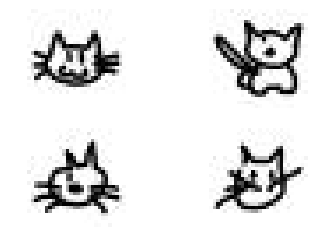

full_numpy_bitmap_dog


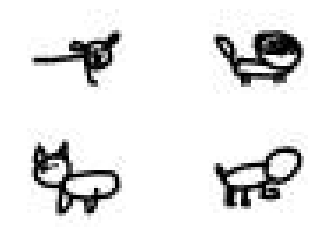

full_numpy_bitmap_grapes


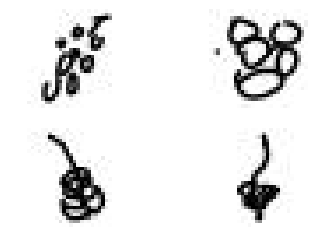

full_numpy_bitmap_pear


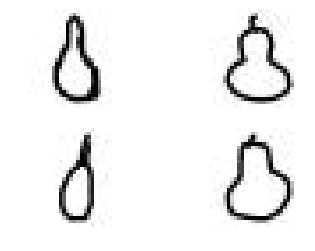

In [57]:
# randomly picks 4 images per class
r, c = 2, 2
for d in os.listdir(out_dir):
    print(d)
    fig, axs = plt.subplots(r, c)
    cnt = 1
    for i in range(r):
        for j in range(c):
            img = plt.imread(out_dir+d+'/'+str(random.randint(1, 100))+'.jpg')
            axs[i, j].imshow(img, cmap=cm.gray)
            axs[i, j].axis('off')
            cnt += 1
    plt.show()
    plt.close()

## Create and verify the data generator

I chose to use a neural network to build the classifier. The reason is two-fold:
- CNN based neural networks are historically proven to be very strong at image classification, identification tasks.
- The test is on Deep Learning! ;-)

So, My idea is to build a multi-task model. First it will try to classify images into $animal$ or $fruit$ classes and then it will further classify among the four classes ($dog$, $cat$, $grapes$, $pear$). 

In [111]:
# few constants
data_path = './data/'
val_data_path = './val_data/'
img_width, img_height, n_channel = 28, 28, 3
img_shape = (img_width, img_height)
batch_size = 32
epoch = 20

In [112]:
# create a generator
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)
train_generator = datagen.flow_from_directory(data_path, target_size=(img_width, img_height)
                    , class_mode='categorical'
                    , batch_size=batch_size, interpolation='nearest'
                    , shuffle=True
                   )
val_generator = ImageDataGenerator(
    rescale=1./255).flow_from_directory(val_data_path, target_size=(img_width, img_height)
                    , class_mode='categorical'
                    , batch_size=batch_size, interpolation='nearest'
                    , shuffle=True
                   )

Found 400 images belonging to 4 classes.
Found 400 images belonging to 4 classes.


Shape of one batch of data:
X shape:  (32, 28, 28, 3)
y shape:  (32, 4)


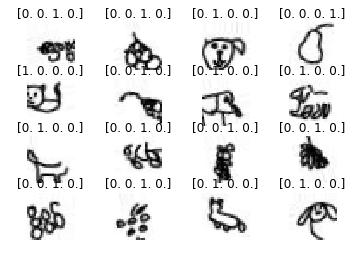

In [113]:
# test how my generator is doing
X, y = next(train_generator) # ask for a batch

print('Shape of one batch of data:')
print('X shape: ', X.shape)
print('y shape: ', y.shape)


r, c = 4, 4 # lets not show entire batch, check rxc images
imgs = X[:r*c]
labels = y[:r*c]
cnt = 0
fig, axs = plt.subplots(r, c)
for i in range(r):
    for j in range(c):
        img = imgs[cnt]
        axs[i, j].imshow(img, cmap=cm.gray)
        axs[i, j].axis('off')
        axs[i, j].set_title(str(labels[cnt]))
        cnt += 1
plt.show()
plt.close()


## Build models

In [158]:
# some model realted constants
latent_dim = 128
epochs = 50
num_a_f_update = 2

In [115]:
# build the animal vs fruit model
def build_a_vs_f_model(input_dim=(img_width, img_height, n_channel), n_classes=2):
    input_ = L.Input(shape=input_dim)
    x = L.Conv2D(32, kernel_size=(3, 3), activation='relu')(input_)
    x = L.Conv2D(64, kernel_size=(3, 3), activation='relu')(x)
    x = L.MaxPooling2D(pool_size=(2, 2))(x)
    x = L.Dropout(0.25)(x)
    x = L.Flatten()(x)
    x = L.Dense(latent_dim, activation='relu')(x)
    feat = L.Dropout(0.5)(x)
    pred = L.Dense(n_classes, activation='softmax')(feat)
    # this is to classify animal vs fruit
    af_model = keras.models.Model(inputs=input_, outputs=pred, name='af_model')
    # idea is to use this layer output as a input feature to the 4 class classification problem
    af_feature_model = keras.models.Model(inputs=input_, outputs=feat, name='feat_model')
    
    af_model.summary()
    return af_model, af_feature_model

In [116]:
# build the 4 class classification model
def build_4class_model(input_dim=(img_width, img_height, n_channel), n_classes=4, latent_dim=128):
    input_img = L.Input(shape=input_dim)
    x = L.Conv2D(32, kernel_size=(3, 3), activation='relu')(input_img)
    x = L.Conv2D(64, kernel_size=(3, 3), activation='relu')(x)
    x = L.MaxPooling2D(pool_size=(2, 2))(x)
    x = L.Dropout(0.25)(x)
    x = L.Flatten()(x)
    x = L.Dense(128, activation='relu')(x)
    
    input_feat = L.Input(shape=(latent_dim,))
    y = L.Concatenate()([x, input_feat])
    y = L.Dense(128)(y)
    y = L.Dropout(0.25)(y)
    y = L.Dense(64)(y)
    y = L.Dropout(0.25)(y)
    y = L.Dense(32)(y)
    y = L.Dropout(0.25)(y)
    pred = L.Dense(n_classes, activation='softmax')(y)
    model = keras.models.Model(inputs=[input_img, input_feat], outputs=pred, name='class4_model')
    model.summary()

    return model

In [117]:
def build_combined_model(feat_model, class4_model):
    inputs = L.Input(shape=(img_width, img_height, n_channel))
    feat = feat_model(inputs)
    pred = class4_model([inputs, feat])
    model = keras.models.Model(inputs=inputs, outputs=pred, name='comb_model')
    model.summary()
    return model

In [159]:
# now, time to train the model
def train_model():
    
    # create models
    a_vs_f_model, feat_model = build_a_vs_f_model()
    class_4_model = build_4class_model()
    combined_model = build_combined_model(feat_model, class_4_model)
    
    # get opts
    a_vs_f_opt = opt.Adam(lr=1E-3, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    comb_opt = opt.Adam(lr=1E-3, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

    a_vs_f_model.trainable = True
    a_vs_f_model.compile(optimizer=a_vs_f_opt, loss='binary_crossentropy', metrics=['acc'])
    
    combined_model.compile(optimizer=comb_opt, loss='categorical_crossentropy', metrics=['acc'])
    
    print(a_vs_f_model.summary())
    print(class_4_model.summary())
    
    # to track losses over epochs
    a_vs_f_losses = []
    class4_losses = []
    comb_losses = []

    
    for epoch in tqdm_notebook(range(epochs)):
        # to keep track of the losses for each epoch
        batch_a_vs_f_losses = []
        batch_class4_losses = []
        batch_comb_losses = []
        
        for idx in tqdm_notebook(range(len(train_generator)), total=len(train_generator)):
            batch_size = len(train_generator[idx][0])
    
            # this generator yields targets of shape (batch_size, 4)
            X = train_generator[idx][0]
            y_4c = train_generator[idx][1]
            # class and how the target looks for y_4c
            # cat     [1, 0, 0, 0]
            # dog     [0, 1, 0, 0]
            # grapes  [0, 0, 1, 0]
            # pear    [0, 0, 0, 1]

            # for a_vs_f model we need target of shape (batch_size, 2)
            # class cat and dog -> [1, 0]
            # class grapes and pear -> [0, 1]
            # how class and the target should look for a_vs_f model
            # cat     [1, 0]
            # dog     [1, 0]
            # grapes  [0, 1]
            # pear    [0, 1]

            y_a_f = np.zeros((y_4c.shape[0], 2))
            for idx, y in enumerate(y_4c):
                if np.all(y == [1, 0, 0, 0]) or np.all(y == [0, 1, 0, 0]):
                    y_a_f[idx] = [1, 0]
                else:
                    y_a_f[idx] = [0, 1]

            # some shape debugs
            # print('Shape of one batch of data:')
            # print('X shape: ', X.shape)
            # print('4c y shape: ', y_4c.shape)
            # print('y a vs f shape:', y_a_f.shape)

            # we are here. we have data X, 4class taget y_4c and 2class target y_a_f
            # time to train!

            for _ in range(num_a_f_update):
                a_vs_f_loss = a_vs_f_model.train_on_batch(X, y_a_f)
                batch_a_vs_f_losses.append(a_vs_f_loss)

            a_vs_f_model.trainable = False

            comb_loss = combined_model.train_on_batch(X, y_4c)
            batch_comb_losses.append(comb_loss)

            a_vs_f_model.trainable = True

            a_vs_f_losses.append(np.mean(batch_a_vs_f_losses))
            comb_losses.append(np.mean(batch_comb_losses))
        print(epoch, np.mean(batch_a_vs_f_losses), np.mean(batch_comb_losses))
        
    return a_vs_f_model, combined_model, a_vs_f_losses, comb_losses
    

In [160]:
a_vs_f_model, combined_model, a_vs_f_losses, comb_losses = train_model()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_76 (InputLayer)        (None, 28, 28, 3)         0         
_________________________________________________________________
conv2d_89 (Conv2D)           (None, 26, 26, 32)        896       
_________________________________________________________________
conv2d_90 (Conv2D)           (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_45 (MaxPooling (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_115 (Dropout)        (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_45 (Flatten)         (None, 9216)              0         
_________________________________________________________________
dense_131 (Dense)            (None, 128)               1179776   
__________

input_77 (InputLayer)           (None, 28, 28, 3)    0                                            
__________________________________________________________________________________________________
conv2d_91 (Conv2D)              (None, 26, 26, 32)   896         input_77[0][0]                   
__________________________________________________________________________________________________
conv2d_92 (Conv2D)              (None, 24, 24, 64)   18496       conv2d_91[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_46 (MaxPooling2D) (None, 12, 12, 64)   0           conv2d_92[0][0]                  
__________________________________________________________________________________________________
dropout_117 (Dropout)           (None, 12, 12, 64)   0           max_pooling2d_46[0][0]           
__________________________________________________________________________________________________
flatten_46

0 0.66108197 0.89946294


1 0.6458694 0.8332708


2 0.6308066 0.8403832


3 0.6429522 0.81015366


4 0.6278258 0.79923767


5 0.621136 0.77095


6 0.62550443 0.7620357


7 0.6226394 0.7790488


8 0.61815333 0.7527669


9 0.61818707 0.75101334


10 0.61555713 0.72439134


11 0.59895337 0.7300214


12 0.6106154 0.7018537


13 0.6026264 0.71941465


14 0.5993612 0.7021374


15 0.6067218 0.7151929


16 0.59735376 0.68616


17 0.58853656 0.7034308


18 0.6039202 0.70962787


19 0.599931 0.6997379


20 0.5947271 0.70148206


21 0.5985383 0.6857696


22 0.5829197 0.6865618


23 0.58594596 0.67117846


24 0.59377885 0.67953616


25 0.58404076 0.6808209


26 0.59655887 0.70126814


27 0.5766632 0.6932418


28 0.57425874 0.65451187


29 0.59434074 0.68135774


30 0.5833709 0.6885407


31 0.58684456 0.6796855


32 0.5929377 0.66904575


33 0.5718031 0.6792643


34 0.58228266 0.6955343


35 0.5753678 0.65765214


36 0.5816511 0.6815333


37 0.5807718 0.6682509


38 0.58003503 0.66884625


39 0.57697535 0.67180514


40 0.5812541 0.6689564


41 0.58136755 0.6585233


42 0.58320993 0.658423


43 0.56859505 0.6689774


44 0.58274955 0.6790265


45 0.5750325 0.6550613


46 0.57803905 0.66455054


47 0.5846336 0.6657886


48 0.57179874 0.63543427


49 0.5952305 0.6626628


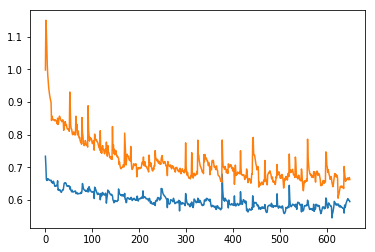

In [161]:
# plot learning curves
plt.plot(a_vs_f_losses)
plt.plot(comb_losses)
plt.show()

In [162]:
# make some predictions
combined_model.evaluate_generator(val_generator, steps=1 + val_generator.n//val_generator.batch_size)

[0.4558197581768036, 0.8575]

In [163]:
combined_model.evaluate_generator(val_generator, steps=1 + val_generator.n//val_generator.batch_size)

[0.5544909155368805, 0.8475]